In [2]:
include("TidalLoveNumbersPorous.jl")
using .TidalLoveNumbers
using DoubleFloats
using PyPlot
using Statistics
using PyCall

@pyimport seaborn as sns
@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec

PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

mpl.style.use("dark_background")

prec = TidalLoveNumbers.prec
precc = TidalLoveNumbers.precc

Complex{Double64}

In [3]:
non_dim = false

G = prec(6.6743e-11)
e = 0.0041

h_core = 700.0 - 690.0
h_mantle_low = 800. + 690
h_mantle_up = 300. - 0.

h_crust = 20.
ω0 = 2*2.047e-5
ω = ω0

#enceladus test model:
n = 2
ρₛ = [3300, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 100e9, 100e9] #.* 10000.0
η = [1e25, 1e25, 1e25, 1e25]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0]
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]
ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)

 
ρ0 = ρ[end]
μ0 = ρ0*g[end,end]*R

Gnd = G*ρ0^2*R^2/μ0;



# Now non-dimensionalise?
T = 2π/ω0

if non_dim
    r = r./R
    ρₛ = ρₛ ./ ρ0
    ρ = ρ ./ ρ0
    μ = μ ./ μ0
    κ = κ ./ μ0
    η = η ./ (μ0 * 2π/ω0 )

    ρₗ = ρₗ ./ ρ0
    κₗ = κₗ ./ μ0
    k = k ./ R^2

    ηₗ = ηₗ ./ (μ0 * 2π/ω0 )


    ω = 2π

    set_G(Gnd)
    g = get_g(r, ρ)

end



In [4]:
res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)


0.17453292519943295

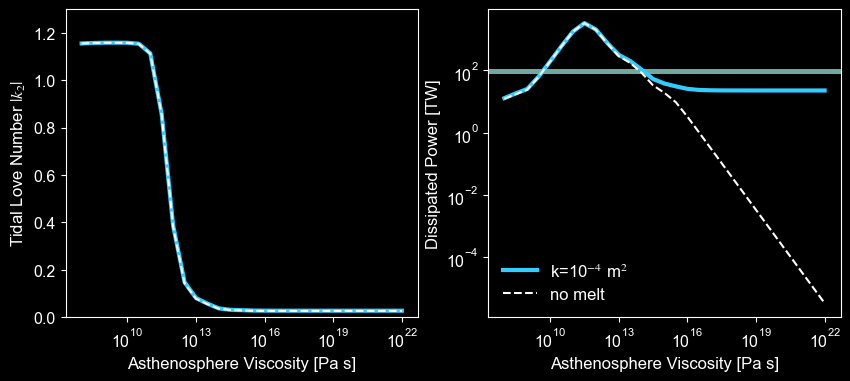

In [7]:
ηs = 8:0.5:22

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1
for j in -4:1:-4
    Edot = zeros(length(ηs))
    Edots = zeros(length(ηs))
    k_ln = zeros(ComplexF64, length(ηs))
    k_lns = zeros(ComplexF64, length(ηs))
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k))
        y2 = ComplexF64.(calculate_y(r, ρ, g, μc, κ))

        # display(y)

        yR = y[:,end,end]
        yR2 = y2[:,end,end]

        k2 = yR[5] - 1
        k22 = yR2[5] - 1

        k_ln[i] = k2
        k_lns[i] = k22
    
        # println(k2)

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Edot[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        Edots[i] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

       

    end

    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), Edot/1e12, label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    
    if j == -4 
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--", label="no melt")
    else
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--")
    end

    cnt += 1
end

axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)

# TESTS 
## Ensure consistent total energy dissipation calculation
### Solid only:

In [4]:
ηs = 8:2:18

ηs = [13]

for j1 in -6:1:-6
    for i1 in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i1] * (non_dim ? 1.0/(μ0*T) : 1.0)
        k[3] = 10.0^j1 * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)
        # μc .= μ     # Fully elastic case

        y = calculate_y(r, ρₛ, g, μc, κ)

        yR = y[:,end,end]

        U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
        U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
        U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

        # global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
        sol_22  = get_solution(y, 2,  2, r, ρₛ, g, μc, κ, res)
        sol_22c = get_solution(y, 2,  -2, r, ρₛ, g, μc, κ, res)
        sol_20  = get_solution(y, 2,  0, r, ρₛ, g, μc, κ, res)

        disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
        # vel = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 
        
        ϵ = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 
        σ = U22E*sol_22[3] + U22W*sol_22c[3] + U20*sol_20[3] 

        k2 = yR[5] - 1

        Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2
        println("Dissipated Energy Total: ", Ediss2/1e9)

        # Now dimensionalise the solutions, if doing non-dimensional calculations
        if non_dim
            disp[:] .*= R
            σ[:] .*= μ0
            p[:] .*= μ0
        end

        Eₛ_vol = zeros(  (size(disp)[1], size(disp)[2], size(disp)[4], size(disp)[5]) )
        Eₛ_total = 0.0

        for j in 2:4#2:size(r)[2]
            for i in 1:size(r)[1]-1

                dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)
                dvol = 4π/3 * (r[i+1, j]^3 - r[i, j]^3)

                # Dissipated energy per unit volume
                Eₛ_vol[:,:,i, j] =   ( sum(σ[:,:,1:3,i,j] .* conj.(ϵ[:,:,1:3,i,j]), dims=3) .- sum(conj.(σ[:,:,1:3,i,j]) .* ϵ[:,:,1:3,i,j], dims=3) ) * 1im 
                Eₛ_vol[:,:,i, j] += 2( sum(σ[:,:,4:6,i,j] .* conj.(ϵ[:,:,4:6,i,j]), dims=3) .- sum(conj.(σ[:,:,4:6,i,j]) .* ϵ[:,:,4:6,i,j], dims=3) ) * 1im 
                Eₛ_vol[:,:,i,j] .*= -0.25ω0

                Eₛ_total += sum(sin.(clats) .* (Eₛ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 

                
            end
        end

        # println("Dissipation in Liquid: $(Eₗ_total/1e9)\nDissipation in Solid:  $(Eₛ_total/1e9)\nSum of dissipation:    $((Eₛ_total + Eₗ_total)/1e9)\nDissipation from k2:   $(Ediss2/1e9)")
        println("$(100*(Eₛ_total - Ediss2)/Ediss2)%")
    end
end


Dissipated Energy Total: 2.70240768417468315219661862272686877e+05
-1.51855063453833188631392654927186453e-01%


### Liquid only: 

In [10]:
ηs = 8:2:18


# fig, ax = subplots()
ηs = [30]

Eη = zero(collect(ηs))

non_dim = false

G = prec(6.6743e-11)
e = 0.0041

h_core = 700.0 - 690.0
h_mantle_low = 800. + 690
h_mantle_up = 300. - 0.

h_crust = 20.
ω0 = 2*2.047e-5
ω = ω0

n = 2
ρₛ = [3300, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 10000000e9, 100e9] 
η = [1e25, 1e25, 1e25, 1e25]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 10000000e9, 0]
κd = 0.95κ
k = [0, 0, 1e-7, 0]

ηₗ = [0, 0, 1e-1, 0]
ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)


for j1 in -6:1:-6
    for i1 in eachindex(ηs)
        #######################################################################
        # η[3] = 10.0^ηs[i1] * (non_dim ? 1.0/(μ0*T) : 1.0)
        # k[3] = 10.0^j1 * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)
        # μc .= μ     # Fully elastic case

        y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k)

        yR = y[:,end,end]

        U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
        U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
        U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

        # global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
        sol_22  = get_solution(y, 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
        sol_22c = get_solution(y, 2,  -2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
        sol_20  = get_solution(y, 2,  0, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)

        disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
        vel = U22E*sol_22[2] + U22W*conj.(sol_22[2]) + U20*sol_20[2] 
        
        ϵ = U22E*sol_22[3] + U22W*sol_22c[3] + U20*sol_20[3] 
        σ = U22E*sol_22[4] + U22W*sol_22c[4] + U20*sol_20[4] 

        p = U22E*sol_22[5] + U22W*sol_22c[5] + U20*sol_20[5] 
        ζ = U22E*sol_22[6] + U22W*sol_22c[6] + U20*sol_20[6] 


        k2 = yR[5] - 1

        Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2

        Eη[i1] = Ediss2
        println("Dissipated Energy Total: ", Ediss2/1e9)

        # Now dimensionalise the solutions, if doing non-dimensional calculations
        if non_dim
            disp[:] .*= R
            vel[:] .*= R / T
            σ[:] .*= μ0
            p[:] .*= μ0
        end

        Eₗ_vol = zeros(  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        Eₛ_vol = zeros(  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        Eₗ_total = 0.0
        Eₛ_total = 0.0

        for j in 3:3#2:size(r)[2]
            for i in 1:size(r)[1]-1

                dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)
                # dvol = 4π/3 * (r[i+1, j]^3 - r[i, j]^3)

                # Dissipated energy per unit volume
                Eₛ_vol[:,:,i, j] =   ( sum(σ[:,:,1:3,i,j] .* conj.(ϵ[:,:,1:3,i,j]), dims=3) .- sum(conj.(σ[:,:,1:3,i,j]) .* ϵ[:,:,1:3,i,j], dims=3) ) * 1im 
                Eₛ_vol[:,:,i, j] += 2( sum(σ[:,:,4:6,i,j] .* conj.(ϵ[:,:,4:6,i,j]), dims=3) .- sum(conj.(σ[:,:,4:6,i,j]) .* ϵ[:,:,4:6,i,j], dims=3) ) * 1im 

                if ϕ[j] > 0
                    Eₛ_vol[:,:,i, j] += ( p[:,:,i,j] .* conj.(ζ[:,:,i,j]) .- conj.(p[:,:,i,j]) .* ζ[:,:,i,j] ) * 1im 
                    Eₗ_vol[:,:,i, j] = 0.5 * ηₗ[j]/k[j] * sum(abs.(vel[:,:,1:3,i,j]).^2, dims=3)# + abs.(vel[:,:,2,i,j]).^2 + abs.(vel[:,:,3,i,j]).^2)
                    Eₗ_vol[:,:,i, j] *= (non_dim ? μ0 * T / R^2 : 1.0) # dimensionalise ηₗ and k
                end

                Eₛ_vol[:,:,i,j] .*= -0.25ω0

                Eₗ_total += sum(sin.(clats) .* (Eₗ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 
                Eₛ_total += sum(sin.(clats) .* (Eₛ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 
 
            end
        end

        println("Dissipation in Liquid: $(Eₗ_total/1e9)\nDissipation in Solid:  $(Eₛ_total/1e9)\nSum of dissipation:    $((Eₛ_total + Eₗ_total)/1e9)\nDissipation from k2:   $(Ediss2/1e9)")
        println("$((Eₗ_total + Eₛ_total - Ediss2)/Ediss2)")


    end
end

# ax.loglog(ηs, Eη)

# display(fig)


Dissipated Energy Total: 2.96548521689169137536750381433265844e-01
Dissipation in Liquid: 3.09443335776437695065663200122046305e-01
Dissipation in Solid:  -1.14381112348985425953909289394882119e-03
Sum of dissipation:    3.08299524652947840806124107228099036e-01
Dissipation from k2:   2.96548521689169137536750381433265844e-01
3.96259030287652449796729121817898151e-02


# Influence of Porosity 

How does porosity control dissipation in the solid?

Dissipation in Solid:  3.28779994094710952573804808876598835e+01 GW
Dissipation in Liquid:  3.64015142347828680719556026441390124e+02 GW
Dissipation from k2:   3.83224314274661210541882154338753545e+02 GW
Dissipation in Liquid: 3.64015142347828680719556026441390124e+02
Dissipation in Solid:  3.28779994094710952573804808876598835e+01
Sum of dissipation:    3.96893141757299775976936507329053951e+02
Dissipation from k2:   3.83224314274661210541882154338753545e+02
Dissipation in Solid:  3.28779994094710952573804808876598835e+01 GW
Dissipation in Liquid:  3.64015142347828680719556026441390124e+02 GW
Dissipation from k2:   3.83224314274661210541882154338753545e+02 GW
Dissipation in Liquid: 3.64015142347828680719556026441390124e+02
Dissipation in Solid:  3.28779994094710952573804808876598835e+01
Sum of dissipation:    3.96893141757299775976936507329053951e+02
Dissipation from k2:   3.83224314274661210541882154338753545e+02
Dissipation in Solid:  3.28779994094710952573804808876598835e+01 GW
Di

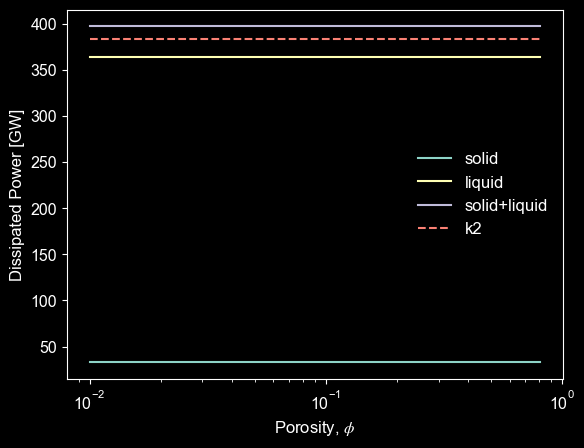

In [8]:
fig, ax = plt.subplots()


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0]
κₛ = [0, 0, 100e9, 0]
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]

η[3] = 1e18

ϕs = 0.01:0.1:0.9


Es = zero(ϕs)
El = zero(ϕs)
Ek2 = zero(ϕs)
for j1 in eachindex(ϕs)
    ϕ[3] =  ϕs[j1]

    ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
    g = get_g(r, ρ)

    #######################################################################
    # η[3] = 10.0^ηs[i1] * (non_dim ? 1.0/(μ0*T) : 1.0)
    # k[3] = 10.0^j1 * (non_dim ? 1.0/R^2 : 1.0)

    μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

    y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k)

    yR = y[:,end,end]

    k2 = yR[5] - 1
    # k2_analy = 3/2 / (1 + 19/2 * μc[end] / (ρ[end]*R*g[end,end]))
    Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2

    U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
    U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
    U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
    # function get_solution(y, n, m, r, ρ, g, μ, K, ω, ρₗ, Kl, Kd, ηₗ, ϕ, k, res=5.0)
    sol_22  = get_solution(y, 2,   2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
    # sol_22c  = get_solution(y, 2,   -2, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, κd, ηₗ, ϕ, k, res)
    sol_20  = get_solution(y, 2,   0, r, ρ, g, μc, κ,  ω, ρₗ, κₗ, ηₗ, ϕ, k, res)

    ϵE = U22E*sol_22[3] + U20*sol_20[3] 
    ϵW = U22W*sol_22[3]

    ϵ = ϵE + conj.(ϵW)

    qE = U22E*sol_22[2] + U20*sol_20[2] 
    qW = U22W*sol_22[2]

    q = qE + conj.(qW)

    Eₛ_total = 0.0
    Eₗ_total = 0.0
    for j in 3:3
        for i in 1:size(r)[1]-1

            dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)

            Eₛ_vol = imag(μc[j]) * ω0 * (sum(abs.(ϵ[:,:,1:3,i,j]).^2, dims=3) .+ 2sum(abs.(ϵ[:,:,4:6,i,j]).^2, dims=3) .- (1/3)*abs.(sum(ϵ[:,:,1:3,i,j], dims=3)).^2 )     # Edot per unit volume
            
            # Eₗ_vol = 0.0
            if ϕ[j] > 0.0
                Eₗ_vol = 0.5 * ηₗ[j]/k[j] * (abs.(q[:,:,1,i,j]).^2 + abs.(q[:,:,2,i,j]).^2 + abs.(q[:,:,3,i,j]).^2)
                Eₗ_total += sum(sin.(clats) .* (Eₗ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate over volume
            end
            
            Eₛ_total += sum(sin.(clats) .* (Eₛ_vol * dr)  * dres^2 * r[i,j]^2.0)    # Integrate over volume
        end
    end

    println("Dissipation in Solid:  $(Eₛ_total/1e9) GW")
    println("Dissipation in Liquid:  $(Eₗ_total/1e9) GW")
    println("Dissipation from k2:   $(Ediss2/1e9) GW")
    Es[j1] = Eₛ_total;
    El[j1] = Eₗ_total;
    Ek2[j1] = Ediss2;

    println("Dissipation in Liquid: $(Eₗ_total/1e9)\nDissipation in Solid:  $(Eₛ_total/1e9)\nSum of dissipation:    $((Eₛ_total + Eₗ_total)/1e9)\nDissipation from k2:   $(Ediss2/1e9)")
    #    # println("$((Eₗ_total + Eₛ_total - Ediss2)/Ediss2)")

end

ax.semilogx(ϕs, Es/1e9, label="solid")
ax.semilogx(ϕs, El/1e9, label="liquid")
ax.semilogx(ϕs, (Es + El)/1e9, label="solid+liquid")
ax.semilogx(ϕs, Ek2/1e9, "--", label="k2")

ax.legend(frameon=false)

ax.set_xlabel("Porosity, \$\\phi\$")
ax.set_ylabel("Dissipated Power [GW]")

fig.savefig("porosity_test_RN22.png", dpi=500)
display(fig)


# Stokes Velocity

In [24]:
n = 2
ρₛ = [3300, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 100e9, 100e9]
η = [1e25, 1e25, 1e18, 1e25]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3

ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 10e9, 0]
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]
ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)

#######################################################################
# η[3] = 10.0^ηs[i1] * (non_dim ? 1.0/(μ0*T) : 1.0)
# k[3] = 10.0^j1 * (non_dim ? 1.0/R^2 : 1.0)

μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k)

yR = y[:,end,end]

U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

# global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
sol_22  = get_solution(y, 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
sol_22c = get_solution(y, 2,  -2, r, ρ, g, μc, κ, -ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
sol_20  = get_solution(y, 2,  0, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)




# disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
vel_east = U22E*sol_22[2] + U20*sol_20[2]; 

# μc =  1im*(-ω)*μ ./ (1im*(-ω) .+ μ ./ η)

# y = calculate_y(r, ρ, g, μc, κ, -ω, ρₗ, κₗ, ηₗ, ϕ, k)

# # yR = y[:,end,end]

# # # global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
# # # sol_22  = get_solution(y, 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
# sol_22c = get_solution(y, 2,  2, r, ρ, g, μc, κ, -ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
# sol_20  = get_solution(y, 2,  0, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)




vel_west = U22W*sol_22c[2]; #
# vel =  U22W*sol_22c[2] #+ U20*sol_20[2]; 


# Get velocity components in thevol_flux asthenosphere
vel_w = vel_east[:,:,1,:,3] .+ conj.(vel_west[:,:,1,:,3]);
vel_v = vel_east[:,:,2,:,3] .+ conj.(vel_west[:,:,2,:,3]);;
vel_u = vel_east[:,:,3,:,3] .+ conj.(vel_west[:,:,3,:,3]);;



6.6743e-11


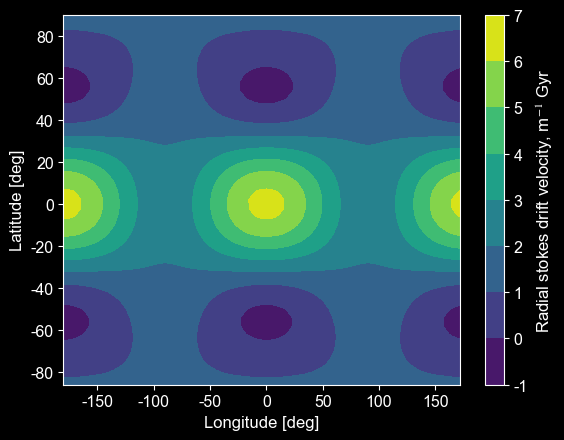

In [28]:
fig, ax = plt.subplots()

dr = (r[2, 3] - r[1, 3])
dwdr = (vel_w[:,:,2:end] .- vel_w[:,:,1:end-1])/dr;
dwdθ = (vel_w[2:end,:,:] .- vel_w[1:end-1,:,:])/deg2rad(res);
dwdϕ =  (vel_w[:,2:end,:] .- vel_w[:,1:end-1,:])/deg2rad(res);

ws = conj.(vel_w[1:end-1,1:end-1,1:end-1]) .* dwdr[1:end-1,1:end-1,:] 
ws .+= (1/R)*conj.(vel_v[1:end-1, 1:end-1, 1:end-1]) .* (dwdθ[:,1:end-1,1:end-1] .- vel_v[1:end-1,1:end-1,1:end-1])
ws .+= (1/R)*conj.(vel_u[1:end-1,1:end-1,1:end-1]) .* (dwdϕ[1:end-1,:,1:end-1] .- vel_u[1:end-1,1:end-1,1:end-1])
ws .-= conj.(ws)
ws .*= 1 / (4im * ω)

vol_flux = zero(ws[:,:,1])
for i in 1:size(ws)[3]
    dr = (r[i+1, 3] - r[i, 3])
    vol_flux .+= ws[:,:,i] * dr
end

c = ax.contourf(lons_deg[1:end-1].-180.0, lats_deg[1:end-1], real.(ws[:,:,150]) * 86400*365*1e9)
# ax.set_aspect("equal")
# ax.s
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
colorbar(c, label="Radial stokes drift velocity, m\$^{-1}\$ Gyr")
fig.savefig("stokes_test.png", dpi=500)
display(fig)

# Patterns

(1, 3)
Dissipated Energy Total: 2.89336560249192821592860989700790778e+01


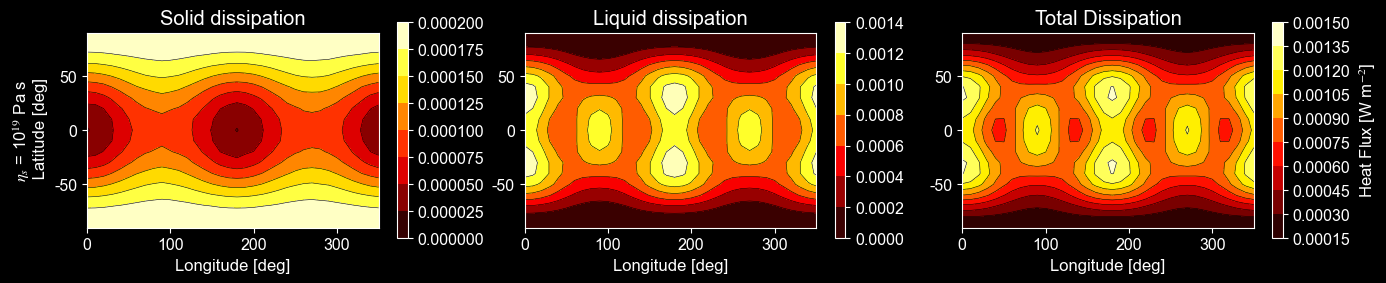

In [8]:
ηs = 8:2:18

ηs = [19]


# fig, axes = plt.subplots(nrows=length(ηs),ncols=3, figsize=(14,3.5))#,figsize=(12,12))
fig, axes = plt.subplots(nrows=length(ηs),ncols=3, figsize=(16,3.5))
axes = reshape(axes, (1, 3))
println(size(axes))

for j in -6:1:-6
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k)

        yR = y[:,end,end]

        U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
        U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
        U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

        # global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
        sol_22  = get_solution(conj.(y), 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
        sol_22c = get_solution(conj.(y), 2, -2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
        sol_20  = get_solution(conj.(y), 2,  0, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)

        disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
        vel = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 
        
        ϵ = U22E*sol_22[3] + U22W*sol_22c[3] + U20*sol_20[3] 
        σ = U22E*sol_22[4] + U22W*sol_22c[4] + U20*sol_20[4] 

        p = U22E*sol_22[5] + U22W*sol_22c[5] + U20*sol_20[5] 
        ζ = U22E*sol_22[6] + U22W*sol_22c[6] + U20*sol_20[6] 


        k2 = yR[5] - 1

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Ediss2 = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        println("Dissipated Energy Total: ", Ediss2/1e9)

        # Now dimensionalise the solutions, if doing non-dimensional calculations
        if non_dim
            disp[:] .*= R
            vel[:] .*= R / T
            σ[:] .*= μ0
            p[:] .*= μ0
        end

        Eₗ_vol = zeros(  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        Eₛ_vol = zeros(  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        Eₛ_area = zeros( (size(vel)[1], size(vel)[2]) )
        Eₗ_area = zeros( (size(vel)[1], size(vel)[2]) )
        Eₗ_total = 0.0
        Eₛ_total = 0.0

        for j in 3:3#2:size(r)[2]
            for i in 1:size(r)[1]-1

                dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)
                dvol = 4π/3 * (r[i+1, j]^3 - r[i, j]^3)

                # Dissipated energy per unit volume
                Eₛ_vol[:,:,i, j] =  ( sum(σ[:,:,1:3,i,j] .* conj.(ϵ[:,:,1:3,i,j]), dims=3) .- sum(conj.(σ[:,:,1:3,i,j]) .* ϵ[:,:,1:3,i,j], dims=3) ) * 1im 
                Eₛ_vol[:,:,i, j] += 2( sum(σ[:,:,4:6,i,j] .* conj.(ϵ[:,:,4:6,i,j]), dims=3) .- sum(conj.(σ[:,:,4:6,i,j]) .* ϵ[:,:,4:6,i,j], dims=3) ) * 1im 

                if ϕ[j] > 0
                    Eₛ_vol[:,:,i, j] += ( p[:,:,i,j] .* conj.(ζ[:,:,i,j]) .- conj.(p[:,:,i,j]) .* ζ[:,:,i,j] ) * 1im 
                    Eₗ_vol[:,:,i, j] = 0.5 * ηₗ[j]/k[j] * (abs.(vel[:,:,1,i,j]).^2 + abs.(vel[:,:,2,i,j]).^2 + abs.(vel[:,:,3,i,j]).^2)
                    Eₗ_vol[:,:,i, j] *= (non_dim ? μ0 * T / R^2 : 1.0) # dimensionalise ηₗ and k
                end

                Eₛ_vol[:,:,i, j] .*= -0.25ω0

                # Integrate across r to find dissipated energy per unit area
                Eₗ_area[:,:] += Eₗ_vol[:, :, i, j] * dr
                Eₛ_area[:,:] .+= Eₛ_vol[:,:, i, j] * dr

                Eₗ_total += sum(sin.(clats) .* (Eₗ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 
                Eₛ_total += sum(sin.(clats) .* (Eₛ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 

                
            end
        end

        # # Eₗ_total += sum(sin.(clats) .* Eₗ_area  * dres^2 * R^2.0) 
        # # Eₛ_total += sum(sin.(clats) .* Eₛ_area  * dres^2 * R^2.0) 
        # println(Eₗ_total / 1e9)
        # println(Eₛ_total / 1e9)

        # println((Eₗ_total + Eₛ_total) / 1e9)

        
        cmap = PyPlot.cm.hot
        c = axes[i,1].contourf(lons_deg, lats_deg, Eₛ_area, cmap=cmap)
        axes[i,1].contour(lons_deg, lats_deg, Eₛ_area, colors="k", linewidths=0.4)
        PyPlot.colorbar(c,shrink=0.8)
        c = axes[i,2].contourf(lons_deg, lats_deg, Eₗ_area, cmap=cmap)
        axes[i,2].contour(lons_deg, lats_deg, Eₗ_area, colors="k", linewidths=0.4)
        PyPlot.colorbar(c,shrink=0.8)
        c = axes[i,3].contourf(lons_deg, lats_deg, Eₗ_area+Eₛ_area, cmap=cmap)
        axes[i,3].contour(lons_deg, lats_deg, Eₗ_area+Eₛ_area, colors="k", linewidths=0.4)
        cb = PyPlot.colorbar(c, shrink=0.8)

        if i == length(ηs)
            cb.set_label("Heat Flux [W m\$^{-2}\$]")
        end

        ##########################################################################################
        # Now solid body  only

        # y = calculate_y(r, ρ, g, μc, κ)

        # yR = y[:,end,end]

        # U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
        # U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
        # U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

        # # global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
        # sol_22  = get_solution(conj.(y), 2,  2, r, ρ, g, μc, κ, res)
        # sol_22c = get_solution(conj.(y), 2, -2, r, ρ, g, μc, κ, res)
        # sol_20  = get_solution(conj.(y), 2,  0, r, ρ, g, μc, κ, res)

        # disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
        # # vel = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 
        
        # ϵ = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 
        # σ = U22E*sol_22[3] + U22W*sol_22c[3] + U20*sol_20[3] 

        # # p = U22E*sol_22[5] + U22W*sol_22c[5] + U20*sol_20[5] 
        # # ζ = U22E*sol_22[6] + U22W*sol_22c[6] + U20*sol_20[6] 


        # k2 = yR[5] - 1

        # # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # # println("k2 = ", yR[5] - 1)  
        # # println("h2 = ", -g[end]*yR[1] )
        # Ediss2 = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

        # # Now dimensionalise the solutions, if doing non-dimensional calculations
        # if non_dim
        #     disp[:] .*= R
        #     vel[:] .*= R / T
        #     # σ[:] .*= μ0
        #     # p[:] .*= μ0
        # end

        # Eₗ_vol = zeros(  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        # Eₛ_vol = zeros(  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        # Eₛ_area = zeros( (size(vel)[1], size(vel)[2]) )
        # Eₗ_area = zeros( (size(vel)[1], size(vel)[2]) )
        # Eₗ_total = 0.0
        # Eₛ_total = 0.0

        # for j in 2:size(r)[2]
        #     for i in 1:size(r)[1]-1

        #         dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)
        #         dvol = 4π/3 * (r[i+1, j]^3 - r[i, j]^3)

        #         # Dissipated energy per unit volume
        #         Eₛ_vol[:,:,i, j] =  ( sum(σ[:,:,1:3,i,j] .* conj.(ϵ[:,:,1:3,i,j]), dims=3) .- sum(conj.(σ[:,:,1:3,i,j]) .* ϵ[:,:,1:3,i,j], dims=3) ) * 1im 
        #         Eₛ_vol[:,:,i, j] += 2( sum(σ[:,:,4:6,i,j] .* conj.(ϵ[:,:,4:6,i,j]), dims=3) .- sum(conj.(σ[:,:,4:6,i,j]) .* ϵ[:,:,4:6,i,j], dims=3) ) * 1im 

        #         # if ϕ[j] > 0
        #         #     Eₛ_vol[:,:,i, j] += ( p[:,:,i,j] .* conj.(ζ[:,:,i,j]) .- conj.(p[:,:,i,j]) .* ζ[:,:,i,j] ) * 1im 
        #         #     Eₗ_vol[:,:,i, j] = 0.5 * ηₗ[j]/k[j] * (abs.(vel[:,:,1,i,j]).^2 + abs.(vel[:,:,2,i,j]).^2 + abs.(vel[:,:,3,i,j]).^2)
        #         #     Eₗ_vol[:,:,i, j] *= (non_dim ? μ0 * T / R^2 : 1.0) # dimensionalise ηₗ and k
        #         # end

        #         Eₛ_vol[:,:,i, j] .*= -0.25ω0

        #         # Integrate across r to find dissipated energy per unit area
        #         # Eₗ_area[:,:] += Eₗ_vol[:, :, i, j] * dr
        #         Eₛ_area[:,:] .+= Eₛ_vol[:,:, i, j] * dr

        #         # Eₗ_total += sum(sin.(clats) .* (Eₗ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 
        #         Eₛ_total += sum(sin.(clats) .* (Eₛ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 

                
        #     end
        # end

        # # # Eₗ_total += sum(sin.(clats) .* Eₗ_area  * dres^2 * R^2.0) 
        # # # Eₛ_total += sum(sin.(clats) .* Eₛ_area  * dres^2 * R^2.0) 
        # # println(Eₗ_total / 1e9)
        # println(Eₛ_total / 1e9)

        # # println((Eₗ_total + Eₛ_total) / 1e9)

        
        # cmap = PyPlot.cm.hot
        # c = axes[i,3].contourf(lons_deg, lats_deg, Eₛ_area, cmap=cmap)
        # axes[i,3].contour(lons_deg, lats_deg, Eₛ_area, colors="k", linewidths=0.4)
        # PyPlot.colorbar(c)
        # c = axes[i,2].contourf(lons_deg, lats_deg, Eₗ_area, cmap=cmap)
        # axes[i,2].contour(lons_deg, lats_deg, Eₗ_area, colors="k", linewidths=0.4)
        # PyPlot.colorbar(c)


        axes[i,1].set_ylabel("\$\\eta_s\$ = 10\$^{$(ηs[i])}\$ Pa s\n Latitude [deg]" )


    end

    # ax2.loglog(ηs, Edot2/1e12, label="Melt, k=\$10^{$(j)}\$ m\$^2\$")
    # ax1.semilogx(ηs, real(k2_2))
end

axes[1,1].set_title("Solid dissipation")
axes[1,2].set_title("Liquid dissipation")
axes[1,3].set_title("Total Dissipation")


axes[1,1].set_aspect(1.3)
axes[1,2].set_aspect(1.3)
axes[1,3].set_aspect(1.3)

axes[end, 1].set_xlabel("Longitude [deg]")
axes[end,2].set_xlabel("Longitude [deg]")
axes[end,3].set_xlabel("Longitude [deg]")

fig.savefig("patterns_v19.png", dpi=500)

display(fig)



# Radial Heating

In [9]:
ηs = 8:1:8

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,9))
# println(size(axes))

for j in -7:1:-5
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k))

        # display(y)

        yR = y[:,end,end]

        U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
        U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
        U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

        # global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
        sol_22  = get_solution(conj.(y), 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
        sol_22c = get_solution(conj.(y), 2, -2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
        sol_20  = get_solution(conj.(y), 2,  0, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)

        disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
        vel = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 
        
        ϵ = U22E*sol_22[3] + U22W*sol_22c[3] + U20*sol_20[3] 
        σ = U22E*sol_22[4] + U22W*sol_22c[4] + U20*sol_20[4] 

        p = U22E*sol_22[5] + U22W*sol_22c[5] + U20*sol_20[5] 
        ζ = U22E*sol_22[6] + U22W*sol_22c[6] + U20*sol_20[6] 


        k2 = yR[5] - 1

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Ediss2 = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        println("Dissipated Energy Total: ", Ediss2/1e9)

        # Now dimensionalise the solutions, if doing non-dimensional calculations
        if non_dim
            disp[:] .*= R
            vel[:] .*= R / T
            σ[:] .*= μ0
            p[:] .*= μ0
        end

        Eₗ_vol = zeros(ComplexF64,  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        Eₛ_vol = zeros(ComplexF64,  (size(vel)[1], size(vel)[2], size(vel)[4], size(vel)[5]) )
        Eₛ_area = zeros(ComplexF64, (size(vel)[1], size(vel)[2]) )
        Eₗ_area = zeros(ComplexF64, (size(vel)[1], size(vel)[2]) )
        Eₗ_total = 0.0
        Eₛ_total = 0.0

        Eₗ_r = zeros((size(vel)[4], size(vel)[5]))
        Eₛ_r = zeros((size(vel)[4], size(vel)[5]))

        for j in 2:size(r)[2]
            for i in 1:size(r)[1]-1

                dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)
                dvol = 4π/3 * (r[i+1, j]^3 - r[i, j]^3)

                # Dissipated energy per unit volume
                Eₛ_vol[:,:,i, j] =  ( sum(σ[:,:,1:3,i,j] .* conj.(ϵ[:,:,1:3,i,j]), dims=3) .- sum(conj.(σ[:,:,1:3,i,j]) .* ϵ[:,:,1:3,i,j], dims=3) ) * 1im 
                Eₛ_vol[:,:,i, j] += 2( sum(σ[:,:,4:6,i,j] .* conj.(ϵ[:,:,4:6,i,j]), dims=3) .- sum(conj.(σ[:,:,4:6,i,j]) .* ϵ[:,:,4:6,i,j], dims=3) ) * 1im 

                if ϕ[j] > 0
                    Eₛ_vol[:,:,i, j] += ( p[:,:,i,j] .* conj.(ζ[:,:,i,j]) .- conj.(p[:,:,i,j]) .* ζ[:,:,i,j] ) * 1im 
                    Eₗ_vol[:,:,i, j] = 0.5 * ηₗ[j]/k[j] * (abs.(vel[:,:,1,i,j]).^2 + abs.(vel[:,:,2,i,j]).^2 + abs.(vel[:,:,3,i,j]).^2)
                    Eₗ_vol[:,:,i, j] *= (non_dim ? μ0 * T / R^2 : 1.0) # dimensionalise ηₗ and k
                end

                Eₛ_vol[:,:,i, j] .*= -0.25ω0

                Eₛ_r[i, j] = sum(sin.(clats) .* Eₛ_vol[:,:,i,j]  * dres^2) / (4pi) # Angular average
                Eₗ_r[i, j] = sum(sin.(clats) .* Eₗ_vol[:,:,i,j]  * dres^2) / (4pi) # Angular average
                
            end
        end

        axes[1,1].semilogx(Eₛ_r[:,3][:], Float64.(r[2:end,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{2}\$")
        axes[1,2].semilogx(Eₗ_r[:,3][:], Float64.(r[2:end,3][:]/1e3))
        axes[2,1].plot(Float64.(abs.(y[7,1:end,3][:])), Float64.(r[2:end,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{2}\$")
        axes[2,2].semilogx(k[3]/ηₗ[3] * Float64.(abs.(y[8,1:end-1,3][:])), Float64.(r[2:end-1,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{2}\$")
        # axes[3].semilogx(Float64.(abs.([8,1:end-1,3][:])), Float64.(r[2:end-1,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")


    end

end

# axes[1,1].set_title("Solid dissipation (two-phase)")
# axes[1,2].set_title("Liquid dissipation (two-phase)")
# axes[1,3].set_title("Solid dissipation (single phase)")

# axes[end, 1].set_xlabel("Longitude [deg]")
# axes[end,2].set_xlabel("Longitude [deg]")
# axes[end,3].set_xlabel("Longitude [deg]")
axes[1,1].set_xlabel("Solid Heating Rate [W m\$^{-3}\$]")
axes[1,2].set_xlabel("Liquid Heating Rate [W m\$^{-3}\$]")
axes[2,1].set_xlabel("Pore pressure [Pa]")
axes[2,2].set_xlabel("Radial Darcy Flux [m s\$^{-1}\$]")

# axes[1,1].set_xlim([1e-7, 1e-6])

axes[1,1].set_ylabel("Radius [km]")
axes[2,1].set_ylabel("Radius [km]")
# axes[1].set_title("Solid Dissipation")
# axes[2].set_title("Liquid Dissipation")
axes[1,1].legend(frameon=false)

subplots_adjust(hspace=0.3)

fig.savefig("radial_profiles_vlow.png", bbox_inches="tight", transparent=true)
display(fig)



InterruptException: Error trying to display an error.

# Total Heating

In [10]:
ηs = 8:0.25:22

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1
for j in -7:1:-6
    Edot = zeros(length(ηs))
    Edots = zeros(length(ηs))
    k_ln = zeros(ComplexF64, length(ηs))
    k_lns = zeros(ComplexF64, length(ηs))
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k))
        y2 = ComplexF64.(calculate_y(r, ρ, g, μc, κ))

        # display(y)

        yR = y[:,end,end]
        yR2 = y2[:,end,end]

        k2 = yR[5] - 1
        k22 = yR2[5] - 1

        k_ln[i] = k2
        k_lns[i] = k22

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Edot[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        Edots[i] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

       

    end

    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), Edot/1e12, label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    
    if j == -4 
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--", label="no melt")
    else
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--")
    end

    # if j == -6
    #     axes[2].semilogx(10.0 .^ηs[1], Edot[1]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+8], Edot[1+8]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+16], Edot[1+16]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+24], Edot[1+24]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+32], Edot[1+32]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+40], Edot[1+40]/1e12, "wo", markersize=3,zorder=100)
    # end    
    # axes[1,2].semilogx(Eₗ_r[:,3][:], Float64.(r[2:end,3][:]/1e3))
    # axes[2,1].plot(Float64.(abs.(y[7,1:end,3][:])), Float64.(r[2:end,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")
    # axes[2,2].semilogx(k[3]/ηₗ[3] * Float64.(abs.(y[8,1:end-1,3][:])), Float64.(r[2:end-1,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")
    # # axes[3].semilogx(Float64.(abs.([8,1:end-1,3][:])), Float64.(r[2:end-1,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")
    cnt += 1
end

axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
axes[1].set_ylim([0,1.3])
fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)



InterruptException: InterruptException:

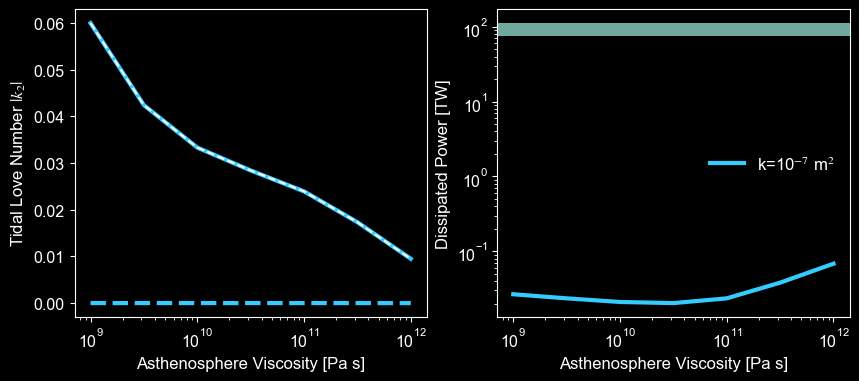

In [11]:
ηs = 8:0.25:22
mus = 9:0.5:12

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1
for j in -7:1:-7
    Edot = zeros(length(mus))
    Edots = zeros(length(mus))
    k_ln = zeros(ComplexF64, length(mus))
    k_lns = zeros(ComplexF64, length(mus))
    for i in eachindex(mus)
        #######################################################################
        # η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        η[3] = 1e21
        μ[3] = 10.0^mus[i]
        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μ, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k))
        y2 = ComplexF64.(calculate_y(r, ρ, g, μ, κ))

        # display(y)

        yR = y[:,end,end]
        yR2 = y2[:,end,end]

        k2 = yR[5] - 1
        k22 = yR2[5] - 1

        k_ln[i] = k2
        k_lns[i] = k22

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Edot[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        Edots[i] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

       

    end

    axes[1].semilogx(10.0 .^ collect(mus), real.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(mus), imag.(k_ln), "--", label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(mus), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(mus), Edot/1e12, label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    
    if j == -4 
        axes[2].loglog(10.0 .^ collect(mus), Edots/1e12, "w--", label="no melt")
    else
        axes[2].loglog(10.0 .^ collect(mus), Edots/1e12, "w--")
    end

    # if j == -6
    #     axes[2].semilogx(10.0 .^ηs[1], Edot[1]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+8], Edot[1+8]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+16], Edot[1+16]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+24], Edot[1+24]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+32], Edot[1+32]/1e12, "wo", markersize=3,zorder=100)
    #     axes[2].semilogx(10.0 .^ηs[1+40], Edot[1+40]/1e12, "wo", markersize=3,zorder=100)
    # end    
    # axes[1,2].semilogx(Eₗ_r[:,3][:], Float64.(r[2:end,3][:]/1e3))
    # axes[2,1].plot(Float64.(abs.(y[7,1:end,3][:])), Float64.(r[2:end,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")
    # axes[2,2].semilogx(k[3]/ηₗ[3] * Float64.(abs.(y[8,1:end-1,3][:])), Float64.(r[2:end-1,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")
    # # axes[3].semilogx(Float64.(abs.([8,1:end-1,3][:])), Float64.(r[2:end-1,3][:]/1e3), label="k=10\$^{$(j)}\$ m\$^{-2}\$")
    cnt += 1
end

axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
# axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)



In [3]:
res = 2.5
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)


0.04363323129985824

In [4]:
# fig, ax = plt.subplots()


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100000000000000e9, 0]
κₛ = [0, 0, 100000000000000e9, 0]
k = [0, 0, 1e-6, 0]

ηₗ = [0, 0, 1e0, 0]

# η[3] = 1e14

ϕs = 0.1:0.1:0.1

ρₛ = [3300, 3300]
r = [0, 
     10, 
     1820] .* 1e3
μ = [60+0im, prec(60)] .* 1e9
κ = [100e9, 100e9] .* 10000.0
η = [1e25, 1e14]

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3

ω = 2.05e-5
ω0 = ω
e = 0.01
non_dim = false
G = prec(6.6743e-11)

ρ = ρₛ
r = expand_layers(r)
g = get_g(r, ρ)

μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

# y = calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k)
y = calculate_y(r, ρ, g, μc, κ)

yR = y[:,end,end]

U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

# global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
# sol_22  = get_solution(y, 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
# sol_22c = get_solution(y, 2,  2, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)
# sol_20  = get_solution(y, 2,  0, r, ρ, g, μc, κ, ω, ρₗ, κₗ, ηₗ, ϕ, k, res)

sol_22  = get_solution(y, 2,   2, r, ρ, g, μc, κ, res)
sol_20  = get_solution(y, 2,   0, r, ρ, g, μc, κ, res)
# sol_20c = get_solution(y, 2,   0, r, ρ, g, μc, κ, res)
# sol_22c = get_solution(y, 2,  -2, r, ρ, g, μc, κ, res)

disp = U22E*sol_22[1]# + U22W*conj.(sol_22c[1]) + U20*sol_20[1] 
# vel = U22E*sol_22[2] + U22W*sol_22c[2] + U20*sol_20[2] 

ϵE = U22E*sol_22[2][:,:,:,:,2] + U20*sol_20[2][:,:,:,:,2] 
ϵW = U22W*sol_22[2][:,:,:,:,2]

σE = U22E*sol_22[3][:,:,:,:,2] + U20*sol_20[3][:,:,:,:,2] 
σW = U22W*sol_22[3][:,:,:,:,2]

ϵ = ϵE + conj.(ϵW)
σ = σE + conj.(σW)
# ϵWc = U22W*conj.(sol_22c[2])

k2 = yR[5] - 1
k2_analy = 3/2 / (1 + 19/2 * μc[end] / (ρ[end]*R*g[end,end]))

println(k2, " ", k2_analy)

Ediss2 = 21.0/2.0 * -imag(k2) * (ω0*R)^5/G * e^2


0.3292039618262175 - 0.5957342941317743im 3.29203495670975765955065661794423671e-01 - 5.95733948249297757470967649377098846e-01im


6.77582876322730901222422749355683846e+14

In [5]:
Eₛ_total = 0.0
Eₛ_vol = zeros(ComplexF64,  (size(disp)[1], size(disp)[2], size(disp)[4]) )
for j in 2:2#2:size(r)[2]
    for i in 1:size(r)[1]-1

        dr = (r[i+1, j] - r[i, j]) * (non_dim ? R : 1.0)

        Eₛ_vol[:,:,i] = sum(abs.(ϵ[:,:,1:3,i]).^2, dims=3) .+ 2sum(abs.(ϵ[:,:,4:6,i]).^2, dims=3)

        Eₛ_vol[:,:,i] .*= imag(μc[j]) * ω0

        Eₛ_total += sum(sin.(clats) .* (Eₛ_vol[:,:,i] * dr)  * dres^2 * r[i,j]^2.0) 

        # Eₛ_vol[:,:,i] .*= -ω0/2.0

        # # Eₗ_total += sum(sin.(clats) .* (Eₗ_vol[:,:,i,j] * dr)  * dres^2 * r[i,j]^2.0) 
        # Eₛ_total += sum(sin.(clats) .* (Eₛ_vol[:,:,i] * dr)  * dres^2 * r[i,j]^2.0) 

    end
end

# println(Eₛ_total/Ediss2)

println("Dissipation in Solid:  $(Eₛ_total/1e9)\nDissipation from k2:   $(Ediss2/1e9)")
# println("$((Eₗ_total + Eₛ_total - Ediss2)/Ediss2)")


Dissipation in Solid:  6.74125268674001382939410708281883953e+05 + 0.0im
Dissipation from k2:   6.77582876322730901222422749355683992e+05


In [15]:
sin.(clats) .* Eₛ_vol[:,:,1]

37×72 Matrix{ComplexF64}:
         0.0-0.0im          0.0-0.0im  …          0.0-0.0im
  1.65531e-5-0.0im   1.65534e-5-0.0im      1.65534e-5-0.0im
  3.24749e-5-0.0im   3.24776e-5-0.0im      3.24776e-5-0.0im
  4.71783e-5-0.0im   4.71871e-5-0.0im      4.71871e-5-0.0im
  6.01598e-5-0.0im   6.01801e-5-0.0im      6.01801e-5-0.0im
   7.1033e-5-0.0im   7.10709e-5-0.0im  …   7.10709e-5-0.0im
  7.95509e-5-0.0im   7.96131e-5-0.0im      7.96131e-5-0.0im
  8.56171e-5-0.0im   8.57101e-5-0.0im      8.57101e-5-0.0im
  8.92855e-5-0.0im    8.9415e-5-0.0im       8.9415e-5-0.0im
   9.0748e-5-0.0im   9.09184e-5-0.0im      9.09184e-5-0.0im
            ⋮                          ⋱  
  8.92855e-5-0.0im    8.9415e-5-0.0im       8.9415e-5-0.0im
  8.56171e-5-0.0im   8.57101e-5-0.0im      8.57101e-5-0.0im
  7.95509e-5-0.0im   7.96131e-5-0.0im  …   7.96131e-5-0.0im
   7.1033e-5-0.0im   7.10709e-5-0.0im      7.10709e-5-0.0im
  6.01598e-5-0.0im   6.01801e-5-0.0im      6.01801e-5-0.0im
  4.71783e-5-0.0im   4.71871e-5